In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load Data

In [2]:
import torchvision
import torchvision.transforms as transforms

# datasets
trainset = torchvision.datasets.FashionMNIST('./data', download=True, train=True)
testset = torchvision.datasets.FashionMNIST('./data', download=True, train=False)

img0, label0 = trainset[0]
img0_array = np.array(img0)
print(img0_array.min(), img0_array.max(), label0)
img0

0 255 9


tensor(-1.) tensor(1.) 9
torch.Size([1, 28, 28])


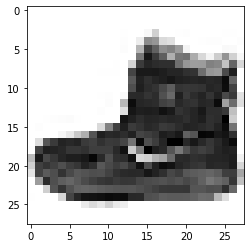

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# transform PIL Images to PyTorch Tensors
transform = transforms.Compose([
    # PIL Image or numpy.ndarray (Height * Width * Channels) in range [0, 255] ->
    # torch.FloatTensor (Channels * Height * Width) in the range [0.0, 1.0]
    transforms.ToTensor(), 
    # Normalize for each channel
    # output = (input - mean) / std
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
testset = torchvision.datasets.FashionMNIST('./data', download=True, train=False, transform=transform)

img0, label0 = trainset[0]
print(img0.min(), img0.max(), label0)
print(img0.size())

plt.imshow(img0[0].numpy(), cmap='Greys')

In [4]:
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Define Network

In [5]:
# This model is nearly identical to that in "60 Minute Blitz". 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # nn.Conv2d(input channels, output channels, kernel size)
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 28*28 -> 12*12
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # 12*12 -> 4*4
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
net = Net()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# TensorBoard Setup

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/fashion_mnist_experiment_1")

# Writing to TensorBoard

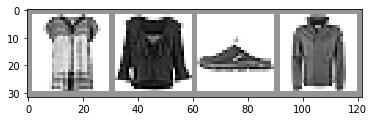

In [8]:
# Get some random images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Create grid of images
img_grid = torchvision.utils.make_grid(images)

# Show images
plt.imshow(img_grid.numpy().mean(axis=0), cmap='Greys')

# Write to TensorBoard
writer.add_image('four_fashion_mnist_images', img_grid)

# Inspect the Model using TensorBoard

In [9]:
writer.add_graph(net, images)
writer.close()

# Adding a Projector to TensorBoard

In [10]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.close()

# Tracking Model Training with TensorBoard

In [11]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        ax.imshow(img_grid.numpy().mean(axis=0), cmap='Greys')
        # matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [12]:
running_loss = 0.0
for epoch in range(1):
    for i, batch in enumerate(trainloader, 0):
        batch_x, batch_y = batch

        # Forward + Loss + Backward + Optimize
        batch_outs = net(batch_x)
        loss = loss_func(batch_outs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 1000 == 0:
            print(epoch, i+1, running_loss/1000)

            # Log the running loss
            writer.add_scalar("training loss", running_loss/1000, epoch*len(trainloader) + i)
            # Log a Matplotlib Figure showing the model's predictions on a random mini-batch
            writer.add_figure('predictions vs. actuals', plot_classes_preds(net, batch_x, batch_y),
                              global_step=epoch*len(trainloader) + i)

            running_loss = 0.0

writer.close()

0 1000 1.7069296799153089
0 2000 0.8490373853333294
0 3000 0.7228811972606927
0 4000 0.660338819055818
0 5000 0.5749094822853804
0 6000 0.5706856685071252
0 7000 0.5397072371901013
0 8000 0.5269392681136961
0 9000 0.4788875129010994
0 10000 0.45875272861658595
0 11000 0.4615493569925893
0 12000 0.4306238478234736
0 13000 0.42924970111786387
0 14000 0.4356872756795492
0 15000 0.3931198005062761
